In [5]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
class PretrainedModel(nn.Module):
    def __init__(self, output_features):
        super().__init__()
        model = models.resnet18(weights="IMAGENET1K_V1")
        model.fc = nn.Linear(model.fc.in_features, output_features)
        self.model = model
        
    def forward(self, x):
        return self.model(x)

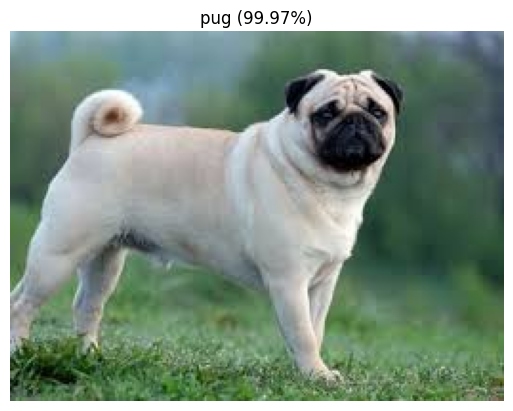

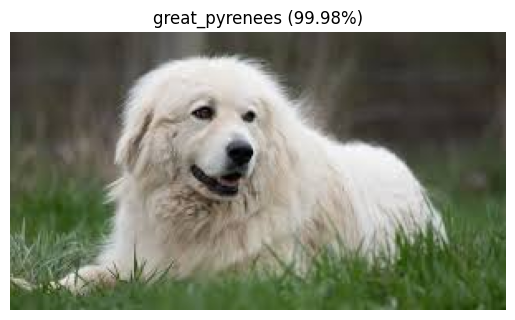

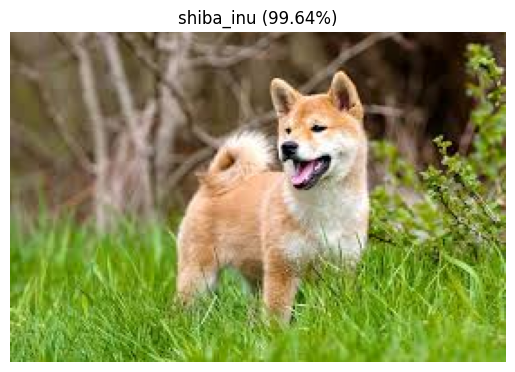

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "best_model.pt"
DEMO_DIR = "demo_images"

CLASS_NAMES = [
    'Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair',
    'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue',
    'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier',
    'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel',
    'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese',
    'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher',
    'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed',
    'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier',
    'wheaten_terrier', 'yorkshire_terrier'
]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

model = PretrainedModel(output_features=len(CLASS_NAMES))
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

for img_file in os.listdir(DEMO_DIR):
    if not img_file.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    img_path = os.path.join(DEMO_DIR, img_file)
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()
        confidence = probs[0][predicted_class].item()
        label = CLASS_NAMES[predicted_class]

    plt.imshow(image)
    plt.title(f"{label} ({confidence:.2%})")
    plt.axis("off")
    plt.show()
